<a href="https://colab.research.google.com/github/neworldemancer/DSF5/blob/master/Solutions_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to machine learning & Data Analysis

Basic introduction on how to perform typical machine learning tasks with Python.

Prepared by Mykhailo Vladymyrov & Aris Marcolongo,
Data Science Lab, University Of Bern, 2023

This work is licensed under <a href="https://creativecommons.org/share-your-work/public-domain/cc0/">CC0</a>.

# Solutions to Part 1.

In [168]:
from sklearn import linear_model
from sklearn import tree
from sklearn import ensemble

from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn import metrics

from matplotlib import  pyplot as plt
import seaborn as sns
sns.set()

import numpy as np
import os
from imageio import imread
import pandas as pd
from time import time as timer

import tensorflow as tf

%matplotlib inline
from matplotlib import animation
from IPython.display import HTML

In [169]:
if not os.path.exists('data'):
    path = os.path.abspath('.')+'/colab_material.tgz'
    tf.keras.utils.get_file(path, 'https://github.com/neworldemancer/DSF5/raw/master/colab_material.tgz')
    !tar -xvzf colab_material.tgz > /dev/null 2>&1

In [ ]:
pip install dtreeviz==1.4.0

In [4]:
from dtreeviz.trees import dtreeviz # remember to load the package

In this course we will use several synthetic and real-world datasets to ilustrate the behavior of the models and excercise our skills.

# Datasets

In this course we will use several synthetic and real-world datasets to illustrate the behavior of the models and exercise our skills.

## 1. Synthetic linear

In [5]:
def get_linear(n_d=1, n_points=10, w=None, b=None, sigma=5):
  x = np.random.uniform(0, 10, size=(n_points, n_d))

  w = w or np.random.uniform(0.1, 10, n_d)
  b = b or np.random.uniform(-10, 10)
  y = np.dot(x, w) + b + np.random.normal(0, sigma, size=n_points)

  print('true slopes: w =', w, ';  b =', b)

  return x, y

true slopes: w = [2.27229645] ;  b = 9.941020788387664


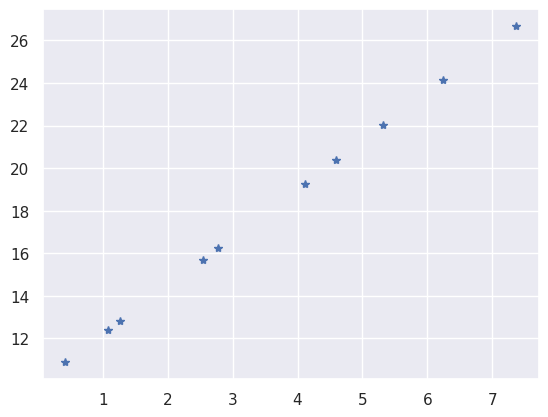

In [6]:
x, y = get_linear(n_d=1, sigma=0)
plt.plot(x[:, 0], y, '*')

true slopes: w = [7.67701313 4.03811358] ;  b = -3.9086555439983606


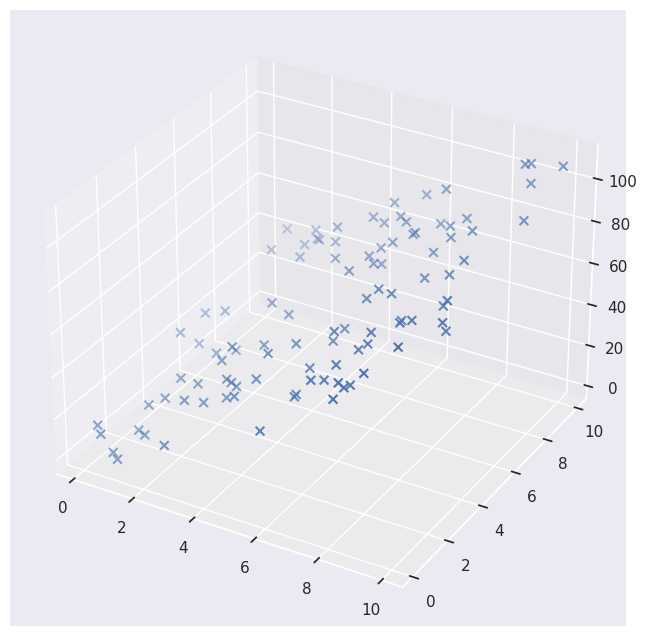

In [7]:
n_d = 2
x, y = get_linear(n_d=n_d, n_points=100)

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[:,0], x[:,1], y, marker='x', color='b',s=40)

## 2. House prices

Subset of the Ames Houses dataset: http://jse.amstat.org/v19n3/decock.pdf

In [170]:
def house_prices_dataset(return_df=False, return_df_xy=False, price_max=400000, area_max=40000):
  path = 'data/AmesHousing.csv'

  df = pd.read_csv(path, na_values=('NaN', ''), keep_default_na=False,  )

  rename_dict = {k:k.replace(' ', '').replace('/', '') for k in df.keys()}
  df.rename(columns=rename_dict, inplace=True)

  useful_fields = ['LotArea',
                  'Utilities', 'OverallQual', 'OverallCond',
                  'YearBuilt', 'YearRemodAdd', 'ExterQual', 'ExterCond',
                  'HeatingQC', 'CentralAir', 'Electrical',
                  '1stFlrSF', '2ndFlrSF','GrLivArea',
                  'FullBath', 'HalfBath',
                  'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
                  'Functional','PoolArea',
                  'YrSold', 'MoSold'
                  ]
  target_field = 'SalePrice'

  df.dropna(axis=0, subset=useful_fields+[target_field], inplace=True)

  cleanup_nums = {'Street':      {'Grvl': 0, 'Pave': 1},
                  'LotFrontage': {'NA':0},
                  'Alley':       {'NA':0, 'Grvl': 1, 'Pave': 2},
                  'LotShape':    {'IR3':0, 'IR2': 1, 'IR1': 2, 'Reg':3},
                  'Utilities':   {'ELO':0, 'NoSeWa': 1, 'NoSewr': 2, 'AllPub': 3},
                  'LandSlope':   {'Sev':0, 'Mod': 1, 'Gtl': 3},
                  'ExterQual':   {'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'ExterCond':   {'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'BsmtQual':    {'NA':0, 'Po':1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex':5},
                  'BsmtCond':    {'NA':0, 'Po':1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex':5},
                  'BsmtExposure':{'NA':0, 'No':1, 'Mn': 2, 'Av': 3, 'Gd': 4},
                  'BsmtFinType1':{'NA':0, 'Unf':1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ':5, 'GLQ':6},
                  'BsmtFinType2':{'NA':0, 'Unf':1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ':5, 'GLQ':6},
                  'HeatingQC':   {'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'CentralAir':  {'N':0, 'Y': 1},
                  'Electrical':  {'':0, 'NA':0, 'Mix':1, 'FuseP':2, 'FuseF': 3, 'FuseA': 4, 'SBrkr': 5},
                  'KitchenQual': {'Po':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'Functional':  {'Sal':0, 'Sev':1, 'Maj2': 2, 'Maj1': 3, 'Mod': 4, 'Min2':5, 'Min1':6, 'Typ':7},
                  'FireplaceQu': {'NA':0, 'Po':1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex':5},
                  'PoolQC':      {'NA':0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex':4},
                  'Fence':       {'NA':0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv':4},
                  }

  df_X = df[useful_fields].copy()
  df_X.replace(cleanup_nums, inplace=True)  # convert continous categorial variables to numerical
  df_Y = df[target_field].copy()

  x = df_X.to_numpy().astype(np.float32)
  y = df_Y.to_numpy().astype(np.float32)

  if price_max>0:
    idxs = y<price_max
    x = x[idxs]
    y = y[idxs]

  if area_max>0:
    idxs = x[:,0]<area_max
    x = x[idxs]
    y = y[idxs]

  return (x, y, df) if return_df else ((x, y, (df_X, df_Y)) if return_df_xy else (x,y))

In [159]:
x, y, df = house_prices_dataset(return_df=True)
print(x.shape, y.shape)
df.head()

(2847, 24) (2847,)


,Order,PID,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NA,IR1,Lvl,...,0,NA,NA,NA,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NA,Reg,Lvl,...,0,NA,MnPrv,NA,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NA,IR1,Lvl,...,0,NA,NA,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NA,Reg,Lvl,...,0,NA,NA,NA,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NA,IR1,Lvl,...,0,NA,MnPrv,NA,0,3,2010,WD,Normal,189900


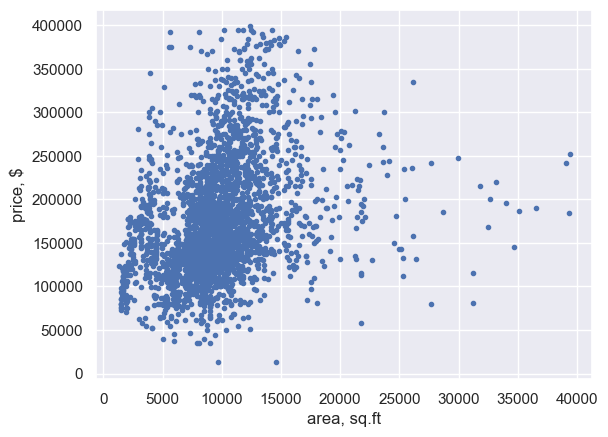

In [160]:
plt.plot(x[:, 0], y, '.')
plt.xlabel('area, sq.ft')
plt.ylabel('price, $');

## 3. Blobs

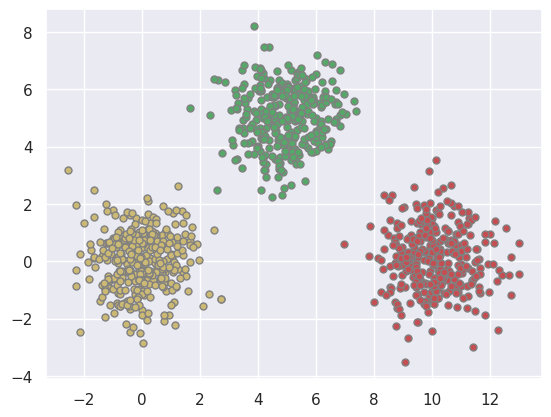

In [11]:
x, y = make_blobs(n_samples=1000, centers=[[0,0], [5,5], [10, 0]])
colors = "ygr"
for i, color in enumerate(colors):
    idx = y == i
    plt.scatter(x[idx, 0], x[idx, 1], c=color, edgecolor='gray', s=25)

## 4. MNIST

The MNIST database of handwritten digits has a training set of 60,000 examples, and a test set of 10,000 examples. The digits have been size-normalized and centered in a fixed-size image.
It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting (taken from http://yann.lecun.com/exdb/mnist/). Each example is a 28x28 grayscale image and the dataset can be readily downloaded from Tensorflow.

In [12]:
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


Let's check few samples:

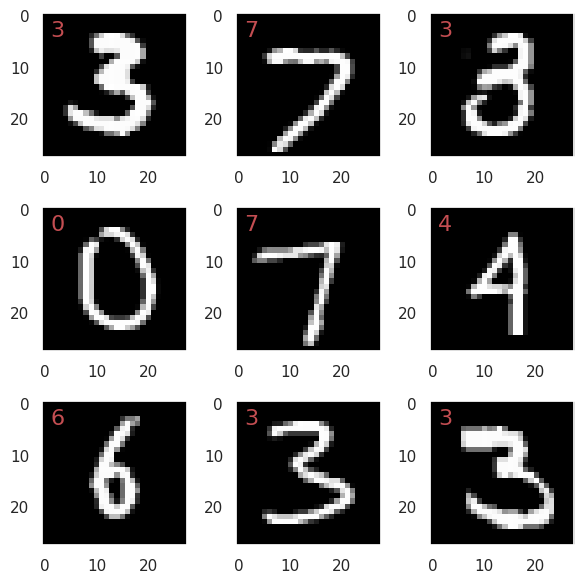

In [13]:
n = 3
fig, ax = plt.subplots(n, n, figsize=(2*n, 2*n))
ax = [ax_xy for ax_y in ax for ax_xy in ax_y]
for axi, im_idx in zip(ax, np.random.choice(len(train_images), n**2)):
  im = train_images[im_idx]
  im_class = train_labels[im_idx]
  axi.imshow(im, cmap='gray')
  axi.text(1, 4, f'{im_class}', color='r', size=16)
  axi.grid(False)
plt.tight_layout()


## 5. Fashion MNIST

`Fashion-MNIST` is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. (from https://github.com/zalandoresearch/fashion-mnist)

In [14]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


Let's check few samples:

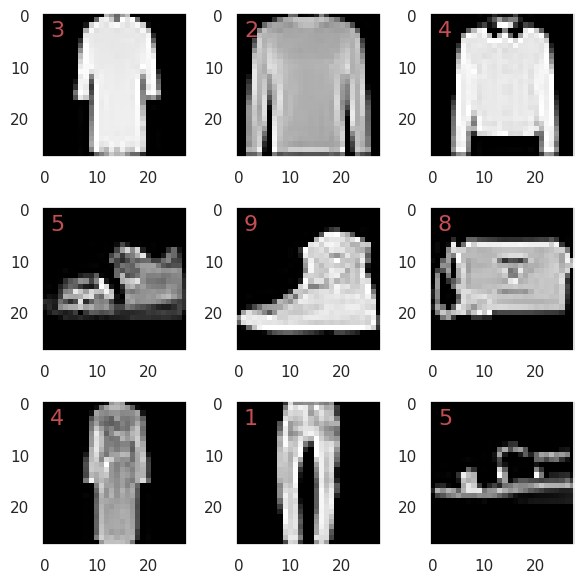

In [15]:
n = 3
fig, ax = plt.subplots(n, n, figsize=(2*n, 2*n))
ax = [ax_xy for ax_y in ax for ax_xy in ax_y]
for axi, im_idx in zip(ax, np.random.choice(len(train_images), n**2)):
  im = train_images[im_idx]
  im_class = train_labels[im_idx]
  axi.imshow(im, cmap='gray')
  axi.text(1, 4, f'{im_class}', color='r', size=16)
  axi.grid(False)
plt.tight_layout()

In [15]:
fmnist_class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

Each of the training and test examples is assigned to one of the following labels:

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

# EXERCISE 1.

train rmse = 26485.447
test rmse = 24672.725
train mae = 18455.957
test mae = 17782.107
train R2 = 0.8399067797238906
test R2 = 0.8560578867571765


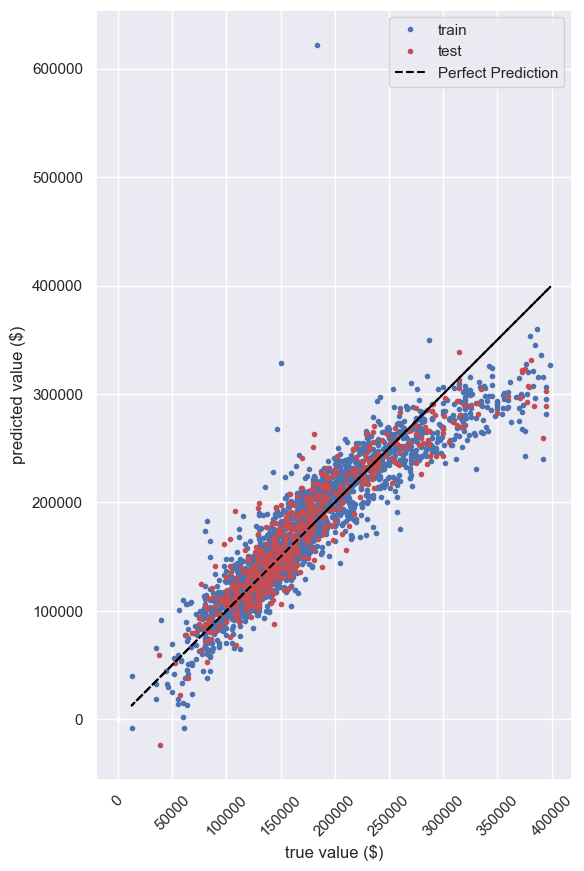

In [178]:
# Solution:
x, y = house_prices_dataset()

# 1. make train/test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

# 2. fit the model
reg = linear_model.LinearRegression()
reg.fit(x_train, y_train)

# 3. evaluate MSE, MAD, and R2 on train and test datasets
#prediction:
y_p_train = reg.predict(x_train)
y_p_test = reg.predict(x_test)

residuals_train = y_train - y_p_train
residuals_test = y_test - y_p_test

# mse
print('train rmse =', np.sqrt( np.mean(residuals_train**2)   ) )
print('test rmse =', np.sqrt( np.mean(residuals_test**2)   ) )
# mse
print('train mae =', np.mean(np.abs(residuals_train)))
print('test mae =', np.mean(np.abs(residuals_test)))
# R2
print('train R2 =', reg.score(x_train, y_train))
print('test R2 =', reg.score(x_test, y_test))

# 4. plot y vs predicted y for test and train parts
plt.figure(figsize=(10,10))
plt.plot(y_train, y_p_train, 'b.', label='train')
plt.plot(y_test, y_p_test, 'r.', label='test')
plt.plot(y_train,y_train,'--',color='black', label='Perfect Prediction')

plt.plot([0], [0], 'w.')  # dummy to have origin
plt.xlabel('true value ($)')
plt.ylabel('predicted value ($)')
_ = plt.xticks(rotation=45)
plt.gca().set_aspect('equal')
plt.legend()


# EXERCISE 2.

In [4]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


We will reshape 2-d images to 1-d arrays for use in scikit-learn:

In [5]:
train_images_norm = train_images / 255.0
test_images_norm = test_images / 255.0

In [134]:
import numpy as np

def extract_features(images):
    def compute_power_spectrum(image):
        fourier_transform = np.fft.fft2(image)
        power_spectrum = np.abs(fourier_transform) ** 2
        power_spectrum /= np.sum(power_spectrum)
        return power_spectrum.flatten()
    power_spectrum_features = []
    for img in images:
        spectrum = compute_power_spectrum(img)
        power_spectrum_features.append(spectrum)
    return np.array(power_spectrum_features)

train_features = extract_features(train_images_norm)
test_features = extract_features(test_images_norm)


Now use a multinomial logistic regression classifier, and measure the accuracy:

In [135]:
#solution
# 1. Create classifier
multi_class = 'multinomial'
clf = linear_model.LogisticRegression(solver='sag', max_iter=20,
                                      multi_class=multi_class)

# 2. fit the model
t1 = timer()
clf.fit(train_features, train_labels)
t2 = timer()
print ('training time: %.1fs'%(t2-t1))

# 3. evaluate accuracy on train and test datasets
print("training score : %.3f" % (clf.score(train_features, train_labels)))
print("test score : %.3f" % (clf.score(test_features, test_labels)))


training time: 28.1s
training score : 0.673
test score : 0.668


/Users/arismarcolongo/miniforge3/envs/tensorflow/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Now we evaluate the confusion matrix, inspect it and print the per class precision and recall:

[[680  11  84  96  40  15  53   3  11   7]
 [ 29 812  14 133   3   0   7   0   2   0]
 [ 73   1 713   9 118   6  66   0   9   5]
 [160  55  13 741  11   3  13   0   3   1]
 [167   3 371  74 294  18  59   0  11   3]
 [  3   1   3   1   0 793   2 132  12  53]
 [245   2 318  51 154  13 179   0  31   7]
 [  0   0   0   0   0  34   0 869  17  80]
 [  5   2  83  10   9  27   5  18 774  67]
 [ 41   0   4   8   4  16  12  71  23 821]]
Check that you get the same accuracy from the score method: 0.6676


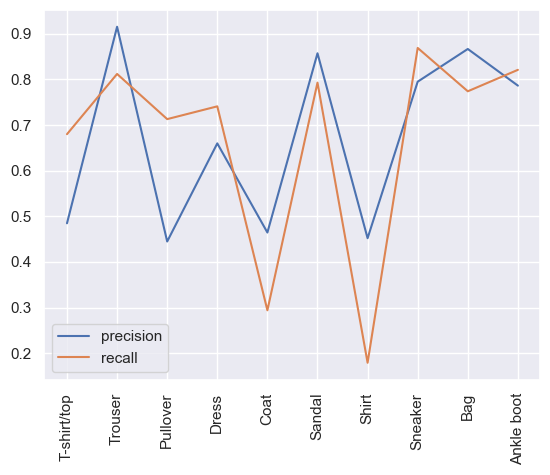

In [136]:
test_labels_pred = clf.predict(test_features)

from sklearn import metrics
cm=metrics.confusion_matrix( test_labels, test_labels_pred )
print(cm)

print(f'Check that you get the same accuracy from the score method: {np.sum([cm[i,i] for i in range(10)])/np.sum(cm)}')

def get_class_specific_prec_recall(cm):
    n_cat=cm.shape[0]
    precisions=[]
    recalls=[]
    #precision
    for i in range(n_cat):
        precisions.append(cm[i,i]/np.sum(cm[:,i]))

    #recall
    for i in range(n_cat):
        recalls.append(cm[i,i]/np.sum(cm[i,:]))
    return precisions, recalls

precisions, recalls = get_class_specific_prec_recall(cm)

plt.plot(fmnist_class_names,precisions, label='precision')
plt.plot(fmnist_class_names,recalls, label='recall')
plt.xticks(rotation=90)
plt.legend()

plt.show()

# EXERCISE 3 : Random forest classifier for FMNIST

In [124]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

train_images_norm = train_images / 255.0
test_images_norm = test_images / 255.0

import numpy as np

def extract_features(images):
    def compute_power_spectrum(image):
        fourier_transform = np.fft.fft2(image)
        power_spectrum = np.abs(fourier_transform) ** 2
        power_spectrum /= np.sum(power_spectrum)
        return power_spectrum.flatten()
    power_spectrum_features = []
    for img in images:
        spectrum = compute_power_spectrum(img)
        power_spectrum_features.append(spectrum)
    return np.array(power_spectrum_features)

train_features = extract_features(train_images_norm)
test_features = extract_features(test_images_norm)


In [142]:
#solution
# 1. Create classifier
clf = ensemble.RandomForestClassifier(max_depth=10, n_estimators=50, n_jobs=-1)

# 2. fit the model
t1 = timer()
clf.fit(train_features, train_labels)
t2 = timer()
print ('training time: %.1fs'%(t2-t1))

# 3. evaluate accuracy on train and test datasets
print("training score : %.3f" % (clf.score(train_features, train_labels)))
print("test score : %.3f" % (clf.score(test_features, test_labels)))

training time: 5.0s
training score : 0.850
test score : 0.791


[[714   1  59 113  26  20  41   0  22   4]
 [  5 911   7  57  12   0   5   0   3   0]
 [ 20   0 690  18 155   6  81   0  27   3]
 [ 37   9  15 873  25   5  28   0   7   1]
 [ 22   0 105  80 681  10  86   0  14   2]
 [  0   0   0   0   0 904   1  71   4  20]
 [195   1 148  90 109  15 387   0  51   4]
 [  0   0   0   0   0  39   0 897   1  63]
 [  4   0  14   4   7  27   8   4 922  10]
 [  4   0   0   3   1  22   1  34   2 933]]
Check that you get the same accuracy from the score method: 0.7912


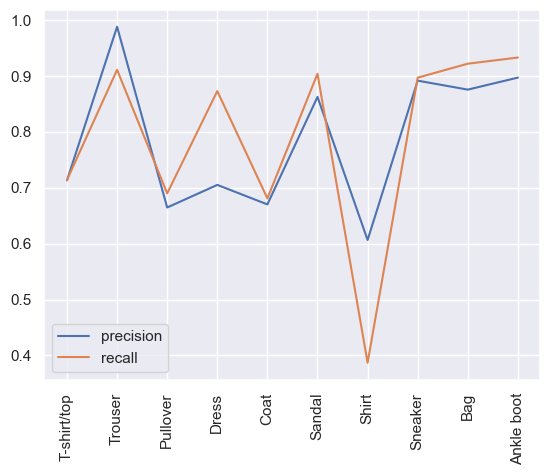

In [143]:
test_labels_pred = clf.predict(test_features)

from sklearn import metrics
cm=metrics.confusion_matrix( test_labels, test_labels_pred )
print(cm)

print(f'Check that you get the same accuracy from the score method: {np.sum([cm[i,i] for i in range(10)])/np.sum(cm)}')

def get_class_specific_prec_recall(cm):
    n_cat=cm.shape[0]
    precisions=[]
    recalls=[]
    #precision
    for i in range(n_cat):
        precisions.append(cm[i,i]/np.sum(cm[:,i]))

    #recall
    for i in range(n_cat):
        recalls.append(cm[i,i]/np.sum(cm[i,:]))
    return precisions, recalls

precisions, recalls = get_class_specific_prec_recall(cm)

plt.plot(fmnist_class_names,precisions, label='precision')
plt.plot(fmnist_class_names,recalls, label='recall')
plt.xticks(rotation=90)
plt.legend()

plt.show()

## EX 3 ADDITIONAL MATERIAL: feature importance

In [144]:
p_importances = permutation_importance(clf, test_features, test_labels, n_repeats=10, n_jobs=-1) #NB: expensive on Colab
rf_importances = clf.feature_importances_

/Users/arismarcolongo/miniforge3/envs/tensorflow/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [145]:
def plot_importances(p_importances, label):
    fig,ax=plt.subplots(1,2,figsize=(19,5))
    y=np.abs(p_importances)
    y=y/np.sum(y)
    ax[0].plot(y)
    ax[0].set_xlabel('Feature index')
    ax[0].set_ylabel(label)
    mod_freq=[]
    for fx in np.fft.fftfreq(28):
        for fy in np.fft.fftfreq(28):
            mod_freq.append(np.sqrt(fx**2+fy**2))
    mod_freq=np.array(mod_freq)
    sorted_indices = np.argsort(mod_freq)
    x = mod_freq[sorted_indices]
    ax[1].plot(x, y[sorted_indices],'-o', markersize=2)
    ax[1].set_xlabel('Wavelength modulus')
    ax[1].set_ylabel(label)
    return fig

Text(0.5, 0.98, 'FMNIST Classification with power spectrum - permutation feature importance')

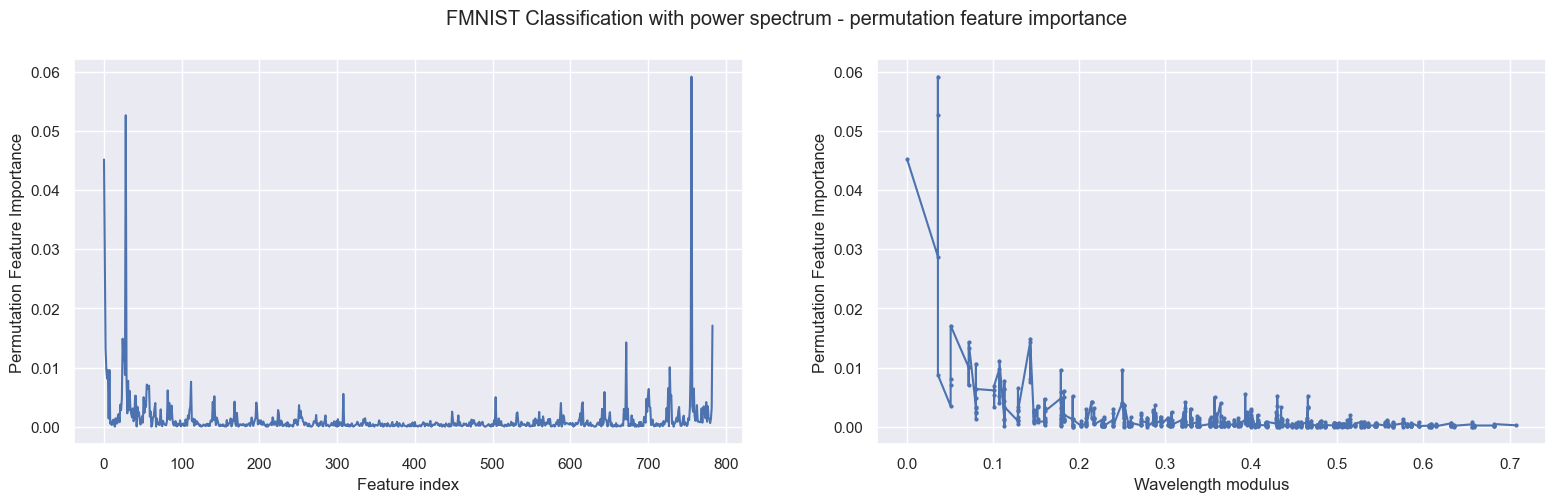

In [155]:
fig=plot_importances(p_importances['importances_mean'], label='Permutation Feature Importance')
fig.suptitle('FMNIST Classification with power spectrum - permutation feature importance')

Text(0.5, 0.98, 'FMNIST Classification with power spectrum - Tree-based feature importance')

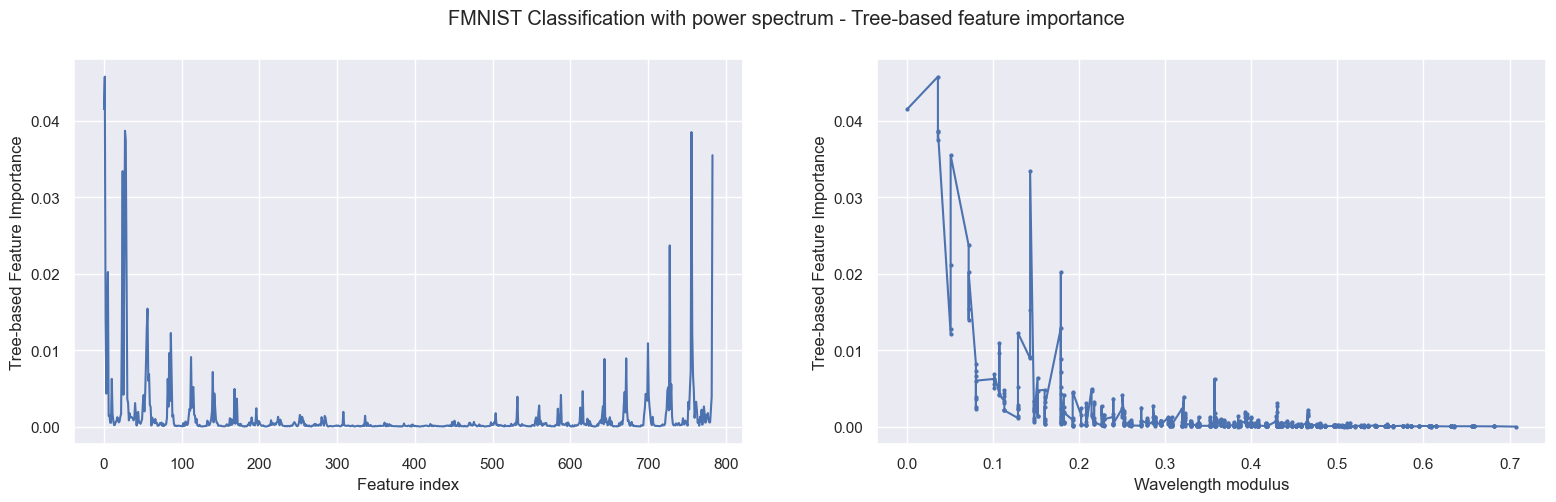

In [156]:
fig=plot_importances(rf_importances, label='Tree-based Feature Importance')
fig.suptitle('FMNIST Classification with power spectrum - Tree-based feature importance')

0.9999999999999999


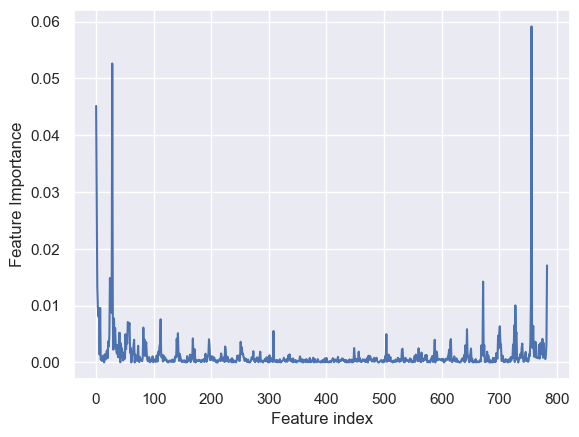

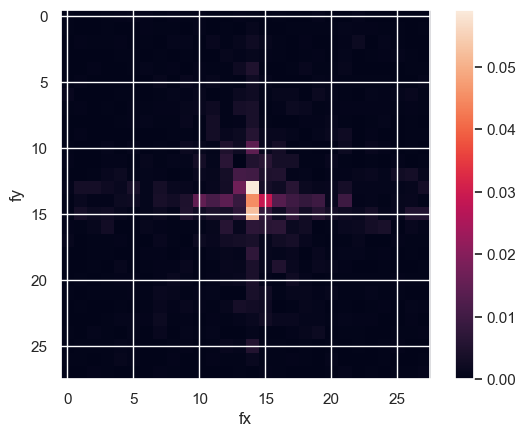

In [151]:
# 2-D visualization of the Feature Importance 

p_importances_reshaped=np.abs(p_importances['importances_mean']).reshape(28,28)
p_importances_reshaped=p_importances_reshaped/np.sum(p_importances_reshaped)
print(np.sum(p_importances_reshaped))
plt.plot(p_importances_reshaped.flatten())
plt.xlabel('Feature index')
plt.ylabel('Feature Importance')
plt.figure()
p_importances_reshaped=np.fft.fftshift(p_importances_reshaped)
plt.imshow(p_importances_reshaped)
plt.xlabel('fx')
plt.ylabel('fy')
plt.colorbar() 


## EXERCISE 4: Random forest/XGboost regression

### Random Forest

In [161]:
X, y, (df_x, df_y) = house_prices_dataset(return_df_xy=True)
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Predict the house prices.

In [162]:
rfr = ensemble.RandomForestRegressor(max_depth=5, n_estimators=30)
rfr.fit(x_train, y_train)
rfr.score(x_test, y_test)

0.8489885663300557

In [163]:
rfr = ensemble.RandomForestRegressor(max_depth=30, n_estimators=70)
rfr.fit(x_train, y_train)
rfr.score(x_test, y_test)

0.8777552663734011

[]

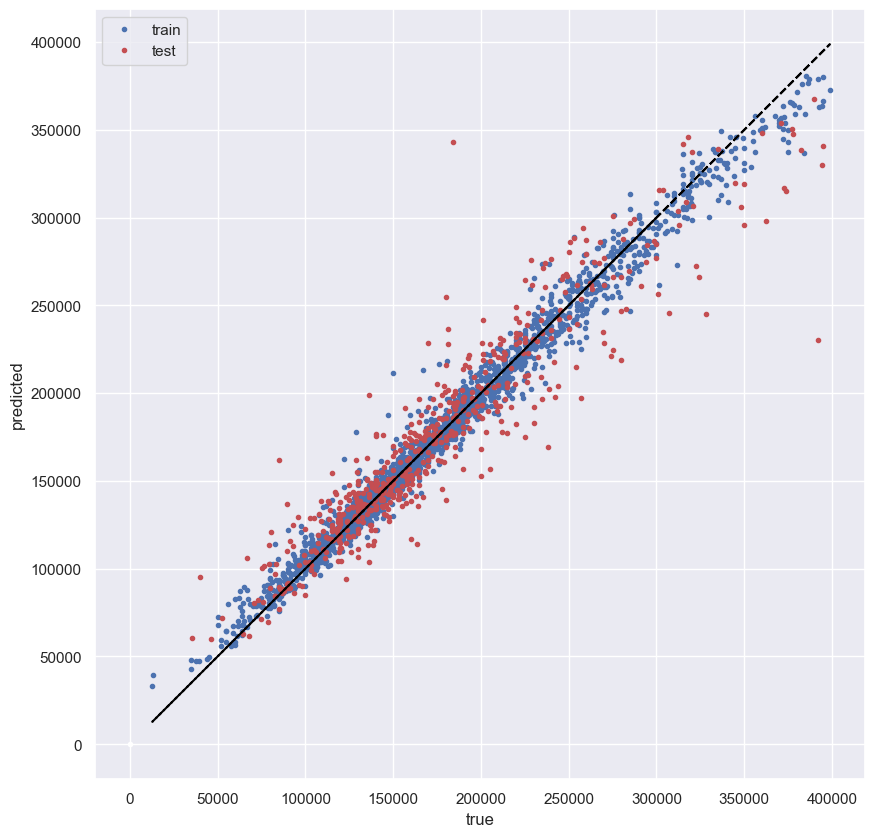

In [164]:
y_p_train = rfr.predict(x_train)
y_p_test = rfr.predict(x_test)


# 4. plot y vs predicted y for test and train parts
plt.figure(figsize=(10,10))
plt.plot(y_train, y_p_train, 'b.', label='train')
plt.plot(y_test, y_p_test, 'r.', label='test')
plt.plot(y_train,y_train,'--',color='black')

plt.plot([0], [0], 'w.')  # dummy to have origin
plt.xlabel('true')
plt.ylabel('predicted')
plt.gca().set_aspect('equal')
plt.legend()
plt.plot()

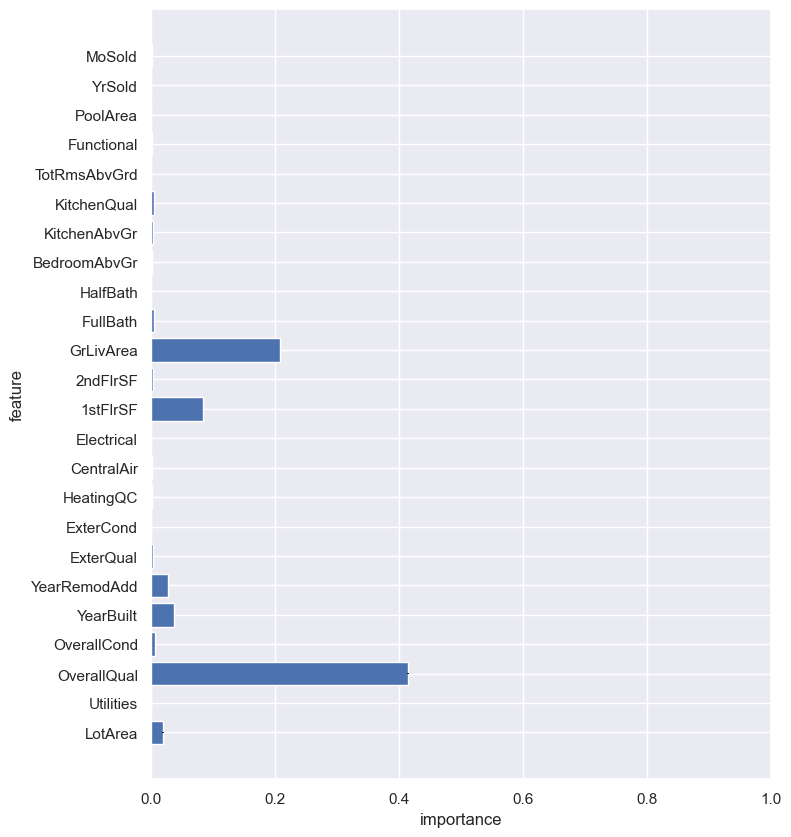

In [167]:
p_importances = permutation_importance(rfr, x_test, y_test, n_repeats=10, n_jobs=-1)

def plot_importances(feature_names, permutation_importances):
        plt.figure(figsize=(8, 10))
        plt.barh(feature_names,
                permutation_importances.importances_mean,
                yerr=permutation_importances.importances_std, )
        plt.ylabel('feature')
        plt.xlabel('importance')
        plt.xlim(0, 1)
        return 

plot_importances(list(df_x.columns), p_importances)

### XGBoost

In [29]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

x, y = house_prices_dataset()

# Split your data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

# Create an XGBoost regression model
model = XGBRegressor(eval_metric='rmse' ,max_depth= 5, learning_rate=0.3, n_estimators=100 )

# Train the XGBoost regression model
model.fit(x_train, y_train, early_stopping_rounds=5, eval_set=[(x_test, y_test)], verbose=True)

y_p_train = model.predict(x_train)
y_p_test = model.predict(x_test)


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:885: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:50014.67721
[1]	validation_0-rmse:39893.69705
[2]	validation_0-rmse:33370.03766
[3]	validation_0-rmse:29349.18071
[4]	validation_0-rmse:26508.41874
[5]	validation_0-rmse:24609.26346
[6]	validation_0-rmse:23474.39640
[7]	validation_0-rmse:22849.27027
[8]	validation_0-rmse:22290.60183
[9]	validation_0-rmse:22041.69864
[10]	validation_0-rmse:21840.80993
[11]	validation_0-rmse:21756.24386
[12]	validation_0-rmse:21704.51007
[13]	validation_0-rmse:21641.87738
[14]	validation_0-rmse:21658.07665
[15]	validation_0-rmse:21650.63144
[16]	validation_0-rmse:21547.43780
[17]	validation_0-rmse:21487.68858
[18]	validation_0-rmse:21459.87305
[19]	validation_0-rmse:21400.73032
[20]	validation_0-rmse:21345.11980
[21]	validation_0-rmse:21377.34320
[22]	validation_0-rmse:21313.74209
[23]	validation_0-rmse:21283.37814
[24]	validation_0-rmse:21276.77992
[25]	validation_0-rmse:21189.81020
[26]	validation_0-rmse:21220.58918
[27]	validation_0-rmse:21237.86160
[28]	validation_0-rmse:21273.3

train mse = 14879.283
test mse = 21183.406
train mae = 10757.099
test mae = 15112.626
train R2 = 0.9496173969811885
test R2 = 0.8926204044774962


[]

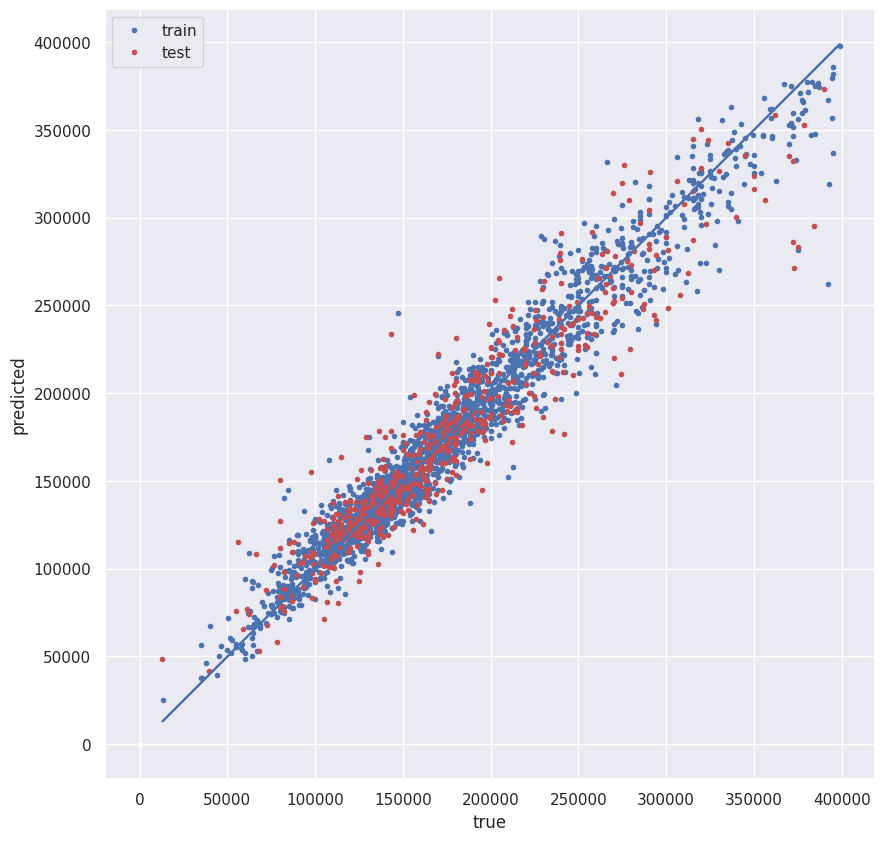

In [30]:
from sklearn.metrics import r2_score

# mse
print('train mse =', np.std(y_train - y_p_train))
print('test mse =', np.std(y_test - y_p_test))
# mse
print('train mae =', np.mean(np.abs(y_train - y_p_train)))
print('test mae =', np.mean(np.abs(y_test - y_p_test)))
# R2
print('train R2 =', r2_score(y_train, y_p_train))
print('test R2 =', r2_score(y_test, y_p_test))

# 4. plot y vs predicted y for test and train parts
plt.figure(figsize=(10,10))
plt.plot(y_train, y_p_train, 'b.', label='train')
plt.plot(y_test, y_p_test, 'r.', label='test')

plt.plot(y_train, y_train,'-')

plt.plot([0], [0], 'w.')  # dummy to have origin
plt.xlabel('true')
plt.ylabel('predicted')
plt.gca().set_aspect('equal')
plt.legend()
plt.plot()

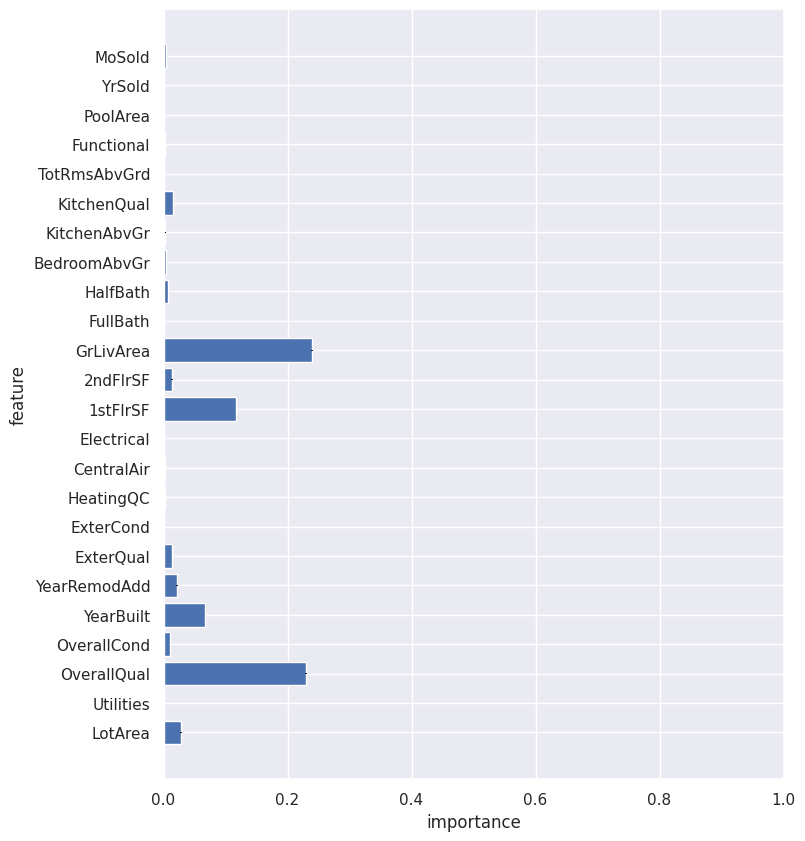

In [31]:
p_importances = permutation_importance(model, x_test, y_test, n_repeats=10, n_jobs=-1)

plt.figure(figsize=(8, 10))
plt.barh(list(df_x.columns),
        p_importances.importances_mean,
        yerr=p_importances.importances_std, )
plt.ylabel('feature')
plt.xlabel('importance')
plt.xlim(0, 1);